# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import cv2

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


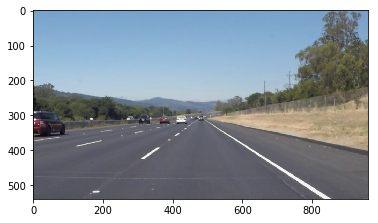

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def get_yellow_and_white(image, white=170, yellow_part=0.9):
    """Pickes yellow and white colors from image.
    We pick white color as color with all coordinates>=white
    We pick yellow  as all colors with red>150 and blue/green<0.9
    
    Of course our goal is to select most white and yellow and to get rid off most non white and non yellow colors
    """
    
    
    
    tmp=(cv2.inRange(image[:,:,0],150,255)  &\
    cv2.inRange(image[:,:,2]/image[:,:,1],0,yellow_part)) | \
    (cv2.inRange(image[:,:,0],white,255) \
    & cv2.inRange(image[:,:,1],white,255)\
    & cv2.inRange(image[:,:,2],white,255))
    
    tmp2=np.where(tmp==0)
    
    image1=image.copy()
    

    image1[tmp2]=[0,0,0]
    return image1

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=1):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)



# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def hough_lines2(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), \
                            minLineLength=min_line_len, maxLineGap=max_line_gap)
    
    #print (lines)
    
    return lines



In [12]:
def get_line (angle, low_coord, max_upper, shp):
    """
    This function get all small parts of left or right line and aggregates it to needed line
    """
    c_angle= angle.mean()
    upper=max_upper.min()
    size=shp[0]-upper
    lower_cord=np.mean(low_coord)
    return [lower_cord,\
            shp[0],\
            lower_cord-size*c_angle,\
            upper]
            

def aggr_lines(lines, image, extrapolate=True):
    #angle of all lines
    angle=(lines[:,0,0]-lines[:,0,2])/(lines[:,0,1]-lines[:,0,3])
    #lenghes of all lines
    length=((lines[:,0,0]-lines[:,0,2])**2+(lines[:,0,1]-lines[:,0,3])**2)**(1/2)
    #bottom coordinates of all lines
    lcords=lines[:,0,0]-(lines[:,0,1]-image.shape[0])*angle
    #upper coordinates of all lines
    max_upper=lines[:,0,[1,3]].min(axis=1)

    #side - array, 1 - left line, 2 - right line
    #we assume line is left if if has slope to right and bottom in the left part of the screen, the same for right line

    side=np.zeros(len(lines), dtype=np.uint8)

    #left
    side[(angle<0) & (angle>-4) & (~np.isnan(angle)) & (lcords>image.shape[1]*0.05) & (lcords<image.shape[1]*0.4)]=1
    #right
    side[(angle>0) & (angle<4) & (~np.isnan(angle)) & (lcords<image.shape[1]*95) & (lcords>image.shape[1]*0.4)]=2

    
    if extrapolate:
        #calculate first and second lines
        is_left, is_right=np.where(side==1 )[0], \
                          np.where(side==2)[0]
        left_line=get_line(angle[is_left],lcords[is_left], max_upper[is_left], image.shape)
        right_line=get_line(angle[is_right],lcords[is_right], max_upper[is_right], image.shape)

        return np.array([[left_line],[right_line]]).astype(np.int32)
    else:
        return lines[side>0]




## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [5]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the test_images directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

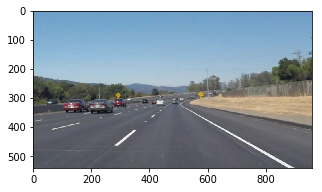

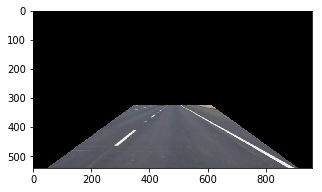

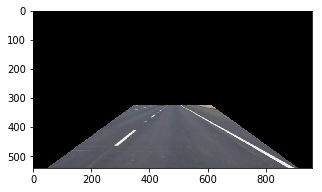

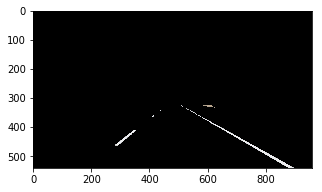

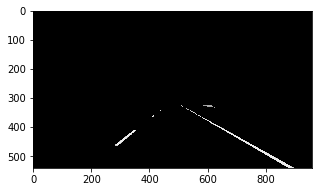

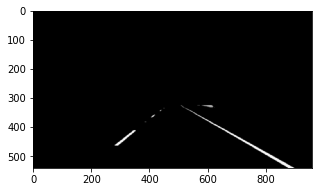

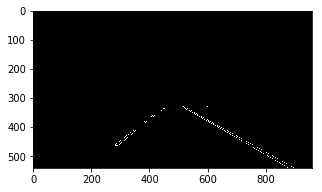

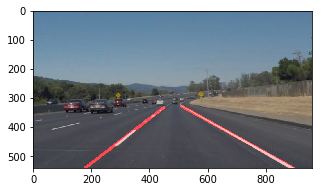

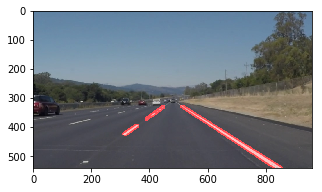

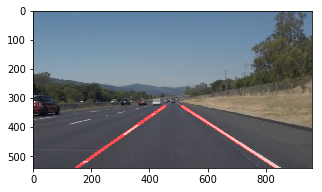

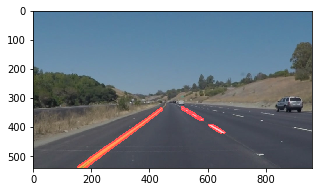

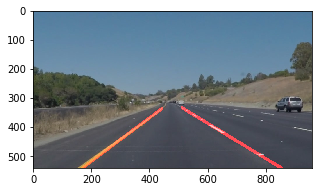

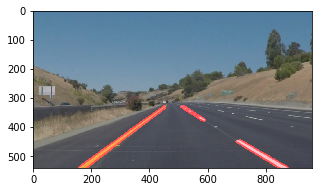

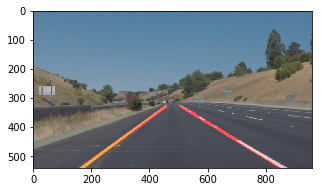

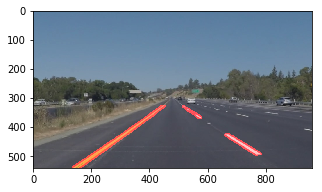

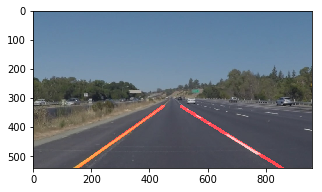

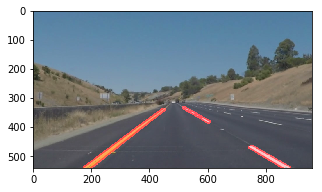

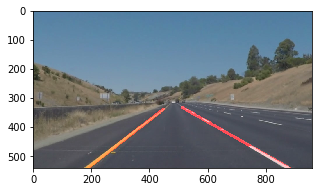

In [17]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.



all_lines=[]
global all_lines

def process_image(image, tr=20, blur=7,white=170,\
                  rho=2, theta=1.0/180, threshold=30, min_line_len=10, max_line_gap=20,
                  verbose=False, a=20, yellow_part=0.9, extrapolate=True):
    
    #we use global variable all_lines to make moving of lines smoothie
    global all_lines

    if verbose:
        p(image,gray=False)
        
    #this is our region of interest - a triangle without a head
    trapece=np.array( [[image.shape[1]*0.05, image.shape[0]],\
                        [image.shape[1]*0.95, image.shape[0]],\
                        [image.shape[1]*0.64,image.shape[0]*0.6],\
                       [image.shape[1]*0.36, image.shape[0]*0.6]], np.int32)

    #this is part of our region - we will cut it a little bit after using canny - to crop region
    trapece2=trapece+np.array([[1,0],[-1,0],[1,1],[-1,1]])*3
    
    
    image0a=region_of_interest(image,[trapece])
    if verbose:
        p(image0a,gray=False)
    
    #the dirty lifehack: here we have to use something to scale our image (for this I used two areas of cropping)
    #or something to chose white/yellow color as a function of meancolor
    
    meancolor=image0a[image0a>0].mean()
    
    if meancolor>120:
        white=190
        yellow_part=0.8
    
    if verbose:
        p(image0a,gray=False)
        
    image0=get_yellow_and_white(image0a, white=white, yellow_part=yellow_part)
    
    if verbose:
        p(image0,gray=False)
    

    image1=grayscale(image0)


    if verbose:
        p(image1)


    image1a=gaussian_blur(image1,blur)
    if verbose:
        p(image1a)
 

    image2=region_of_interest(canny(image1a,tr,tr*3),[trapece2])
    if verbose:
        p(image2)


    lines=hough_lines2(image2,rho, theta, threshold, min_line_len, max_line_gap)
    lines2=aggr_lines(lines,image, extrapolate)
    all_lines.append(lines2)
    
    if extrapolate:
        current_lines=np.array(all_lines[-a:]).mean(axis=(0)).astype(np.int32)
    else:
        current_lines=lines2                                       

    line_img = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, current_lines,thickness=10)



    image6=weighted_img(line_img, image)
    return image6

def p(image, gray=True):
    plt.figure(figsize=(5,5))
    if gray:
        plt.imshow(image,cmap='gray')
    else:
        plt.imshow(image)
    plt.show()


files=os.listdir("test_images/")

#one example of all stages
image = mpimg.imread("test_images/"+files[0])
p(process_image(image,verbose=True))
    
    
#and just other files
for path in files[1:]:
    all_lines=[]
    image = mpimg.imread("test_images/"+path)
    p(process_image(image,verbose=False, extrapolate=False))
    all_lines=[]
    p(process_image(image,verbose=False, extrapolate=True))
    
    

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [8]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Let's try the one with the solid white lane on the right first ...

In [19]:
global all_lines


for out,v_in in (('white','solidWhiteRight.mp4'),('yellow','solidYellowLeft.mp4'),('extra','challenge.mp4')):

    all_lines=[]

    white_output = '%s.mp4' % out
    clip1 = VideoFileClip(v_in)
    white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
    %time white_clip.write_videofile(white_output, audio=False)

    all_lines=[]

    white_output = '%s_segments.mp4' % out
    clip1 = VideoFileClip(v_in)
    white_clip = clip1.fl_image(lambda x:process_image(x,extrapolate=False)) #NOTE: this function expects color images!!
    %time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:10<00:00, 21.95it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 8.49 s, sys: 1.67 s, total: 10.2 s
Wall time: 10.9 s
[MoviePy] >>>> Building video white_segments.mp4
[MoviePy] Writing video white_segments.mp4


100%|█████████▉| 221/222 [00:10<00:00, 21.90it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white_segments.mp4 

CPU times: user 8.64 s, sys: 1.68 s, total: 10.3 s
Wall time: 11.3 s
[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:36<00:00, 18.89it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 28.3 s, sys: 5.56 s, total: 33.9 s
Wall time: 36.8 s
[MoviePy] >>>> Building video yellow_segments.mp4
[MoviePy] Writing video yellow_segments.mp4


100%|█████████▉| 681/682 [00:33<00:00, 20.50it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow_segments.mp4 

CPU times: user 27 s, sys: 5.23 s, total: 32.3 s
Wall time: 34.3 s
[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:23<00:00, 11.57it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 17.8 s, sys: 4.03 s, total: 21.9 s
Wall time: 25.2 s
[MoviePy] >>>> Building video extra_segments.mp4
[MoviePy] Writing video extra_segments.mp4


100%|██████████| 251/251 [00:24<00:00, 11.81it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra_segments.mp4 

CPU times: user 17.7 s, sys: 4.38 s, total: 22.1 s
Wall time: 25.9 s
